## MonteCarlo Simulation of Team Results

In [1]:
import pandas as pd
import numpy as np
from dimod import BinaryQuadraticModel
from dwave.system import LeapHybridSampler
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import cirq
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10,8)

In [65]:
df = pd.read_csv('basket.csv')

df.loc[df.PTS > df['PTS.1'], 'Winner'] = df['Visitor']
df.loc[df.PTS < df['PTS.1'], 'Winner'] = df['Home']

df.loc[df.PTS > df['PTS.1'], 'Loser'] = df['Home']
df.loc[df.PTS < df['PTS.1'], 'Loser'] = df['Visitor']

df['VisitorPPG'] = df.groupby('Visitor')['PTS'].transform(np.mean)
df['HomePPG'] = df.groupby('Home')['PTS.1'].transform(np.mean)

df.head()

,Date,Start (ET),Visitor,PTS,Home,PTS.1,Attend.,Winner,Loser,VisitorPPG,HomePPG
0,"Tue, Dec 22, 2020",7:00p,Golden State Warriors,99,Brooklyn Nets,125,0,Brooklyn Nets,Golden State Warriors,110.75,127.000000
1,"Tue, Dec 22, 2020",10:00p,Los Angeles Clippers,116,Los Angeles Lakers,109,0,Los Angeles Clippers,Los Angeles Lakers,118.50,120.250000
2,"Wed, Dec 23, 2020",7:00p,Charlotte Hornets,114,Cleveland Cavaliers,121,300,Cleveland Cavaliers,Charlotte Hornets,116.00,108.333333
3,"Wed, Dec 23, 2020",7:00p,New York Knicks,107,Indiana Pacers,121,0,Indiana Pacers,New York Knicks,95.00,114.750000
4,"Wed, Dec 23, 2020",7:00p,Miami Heat,107,Orlando Magic,113,"3,396",Orlando Magic,Miami Heat,107.00,102.500000


## Classical MonteCarlo

The montecarlo step looks for each matchup if the average PPG (points per game) for the visiting team is greater than the home team's average multiplied by a weight which is determined randomly. Each iteration is captured in the sim dictionary and we plot the mean of the 100 simulations for each team in the bar plot below.

In [6]:
sim = {}

for j in range(100):

    games = []

    for i in range(len(df)):
        if df['VisitorPPG'][i] > 0.8*np.exp(np.random.rand(1))*df['HomePPG'][i]:
            games.append(df['Visitor'][i])
        else:
            games.append(df['Home'][i])
            
        cts = Counter(games)
        sim[j] = list(cts.items())

In [7]:
tms = {}

for i in range(100):
    for j in sim[i]:
        try:
            tms[j[0]].append(j[1])
            
        except:
            tms[j[0]] = [j[1]]

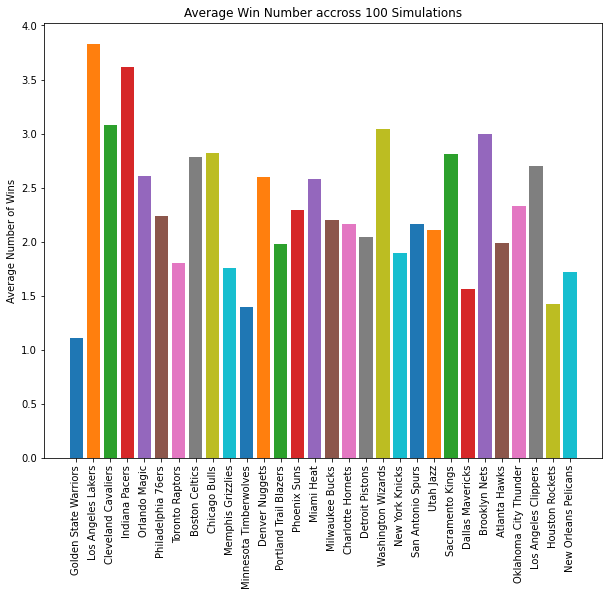

In [8]:
for i, v in tms.items():
    #print(i, np.mean(v))
    plt.bar(i, np.mean(v))
    plt.xticks(rotation = 90)
    plt.title('Average Win Number accross 100 Simulations')
    plt.ylabel('Average Number of Wins')

Comparing with the actual result we see the simulation does quite well. Brooklyn had 3 wins in the actual games; the simulations projected them to have 3.1 wins.

In [9]:
##actual results####

df.loc[df.Visitor == df.Winner, 'VisitorWin'] = 1
df.loc[df.Home == df.Winner, 'HomeWin'] = 1

gb_wins = df.groupby(['Visitor'])['VisitorWin'].sum() + df.groupby(['Home'])['HomeWin'].sum()
gb_wins

Atlanta Hawks             3.0
Boston Celtics            3.0
Brooklyn Nets             3.0
Charlotte Hornets         2.0
Chicago Bulls             2.0
Cleveland Cavaliers       3.0
Dallas Mavericks          1.0
Denver Nuggets            1.0
Detroit Pistons           0.0
Golden State Warriors     NaN
Houston Rockets           1.0
Indiana Pacers            4.0
Los Angeles Clippers      4.0
Los Angeles Lakers        3.0
Memphis Grizzlies         1.0
Miami Heat                2.0
Milwaukee Bucks           2.0
Minnesota Timberwolves    2.0
New Orleans Pelicans      3.0
New York Knicks           2.0
Oklahoma City Thunder     1.0
Orlando Magic             4.0
Philadelphia 76ers        4.0
Phoenix Suns              4.0
Portland Trail Blazers    2.0
Sacramento Kings          3.0
San Antonio Spurs         2.0
Toronto Raptors           1.0
Utah Jazz                 2.0
Washington Wizards        0.0
dtype: float64

We show a simple distribution for the number of wins that Toronto had over the 100 simulations. 

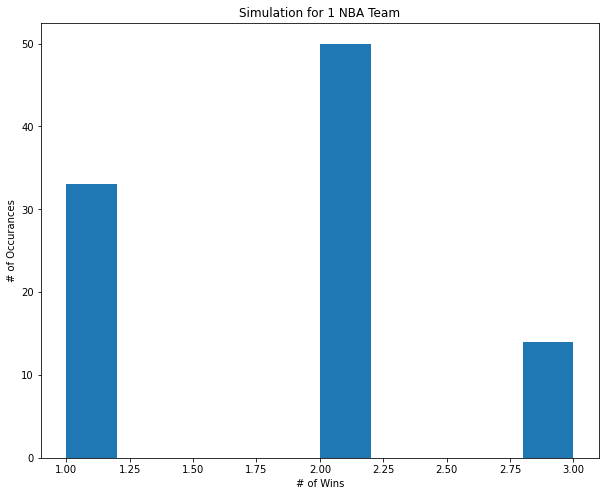

In [67]:
plt.title('Simulation for 1 NBA Team')
plt.ylabel('# of Occurances')
plt.xlabel('# of Wins')
plt.hist(tms['Toronto Raptors']);

## Quantum MonteCarlo

For the quantum random walk we allow the measurement of the qubit in the x basis determine the number of games a particular team would win over 5 matches (where a 1 would represent a win, and a 0 would represent a loss). 

In [36]:
qubit = cirq.GridQubit(0, 0)

circuit = cirq.Circuit(
    cirq.X(qubit)**0.5,  
    cirq.measure(qubit, key='m')  
)
print("Circuit:")
print(circuit)

Circuit:
(0, 0): ───X^0.5───M('m')───


In [44]:
lst = []

for i in range(100):
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=5)
    lst.append(result)
    

In [55]:
dicts ={}

for i in lst:
    try:
        dicts[str(i)].append(1)
    except:
        dicts[str(i)] = [1]

In [71]:
wins = []

for i in lst:
    wins.append(list(Counter(str(i)).items())[2][1])

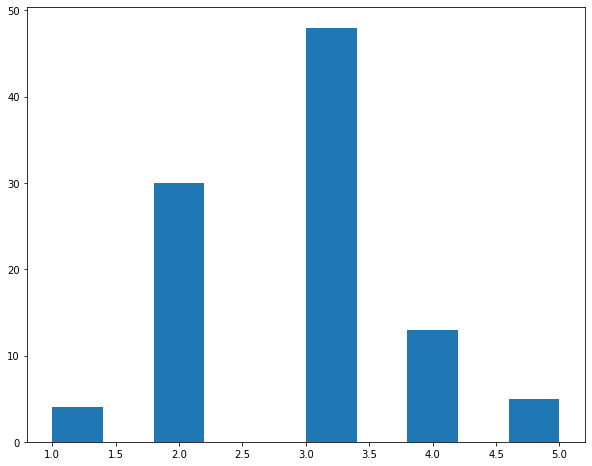

In [72]:
plt.hist(wins);
plt.title('Simulation for 1 NBA Team')
plt.ylabel('# of Occurances')
plt.xlabel('# of Wins')
plt.hist(tms['Toronto Raptors']);

The number of occurances for each state (preserving order)

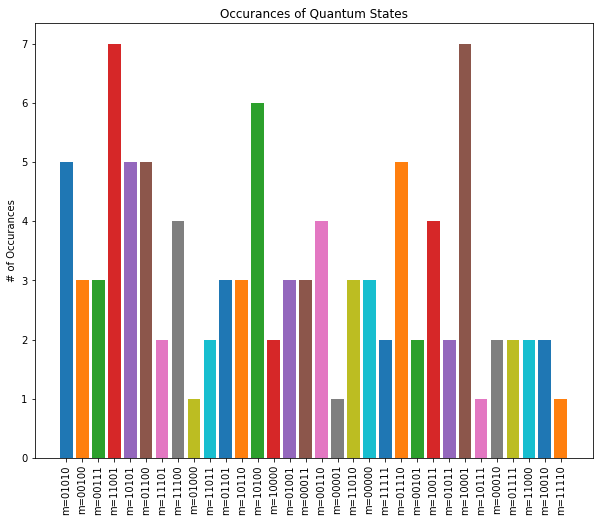

In [64]:
for i,v in dicts.items():
    plt.bar(i, len(v))
    plt.xticks(rotation = 90)
    plt.title('Occurances of Quantum States')
    plt.ylabel('# of Occurances')